In [4]:
import pandas, numpy, seaborn, umap
import sklearn, sklearn.manifold, sklearn.preprocessing

import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(8, 4)})
from  sklearn.decomposition import  PCA
from scipy.stats import entropy
import scipy.stats

# 0. user-defined data

In [5]:
# files should not have spaces
optimal_data_set_file = '/Users/farhadzare/Desktop/Endothelium/optimal_dataset.csv' 
optimal_data_set_names_file = '/Users/farhadzare/Desktop/Endothelium/optimal_dataset_list.csv'
metadata_folder = '/Users/farhadzare/Desktop/Endothelium/metadata/'

# 1. read data & metadata

## 1.1. read data

In [6]:
# restrict df to generic temporal variables. Use variable names that reflect their contents
expression = pandas.read_csv(optimal_data_set_file)
expression.drop(["Unnamed: 0"], axis='columns', inplace=True)
expression = expression.set_index("Feature")
expression.rename_axis(None, inplace=True)

print(expression.shape)
expression.head()

(4998, 2636)


,GSM752709.cel,GSM752710.cel,GSM752711.cel,GSM752712.cel,GSM752713.cel,GSM752714.cel,GSM752715.cel,GSM752716.cel,GSM752717.cel,GSM752718.cel,...,GSM46386.CEL,GSM46387.CEL,GSM46388.CEL,GSM46389.CEL,GSM46390.CEL,GSM46391.CEL,GSM46392.CEL,GSM46393.CEL,GSM46394.CEL,GSM46395.CEL
100,6.082276,6.296477,5.678143,5.903716,6.561618,6.563634,6.315923,6.285618,6.213070,6.462815,...,6.277586,6.319818,6.377999,6.527582,6.489835,6.624150,8.837815,8.586964,6.352242,6.281925
1000,8.910453,9.094440,9.018398,8.981716,9.903595,9.752144,10.060706,10.016482,10.449370,10.395254,...,8.676218,8.441180,8.843971,8.998472,8.892125,8.860669,9.992499,10.019584,8.024033,7.984392
10000,3.903745,3.573659,3.750108,4.090731,3.960562,3.867853,3.701989,3.649789,3.906663,3.963748,...,6.441616,6.292823,6.226290,6.620311,6.222595,6.497028,7.098504,7.330978,6.436398,6.473776
10005,5.963907,6.097107,5.790247,5.761399,6.016096,6.124152,6.104648,5.986309,5.860771,6.024226,...,7.281914,7.315629,7.086792,7.135733,7.045656,6.585559,7.457399,8.094391,6.995187,7.402195
10006,7.752008,7.465366,7.941747,7.606796,7.469340,7.268851,7.641408,7.385734,7.565066,7.325005,...,6.486721,6.146278,5.913813,5.738923,6.470929,6.267256,6.340759,7.332293,5.348349,5.980073


In [7]:
transpose_expression = expression.transpose()
transpose_expression.head()

,100,1000,10000,10005,10006,10007,10010,10013,10015,10019,...,9978,998,9984,9987,9988,9989,9990,9991,9993,9994
GSM752709.cel,6.082276,8.910453,3.903745,5.963907,7.752008,7.375102,5.187760,5.620045,10.513556,9.541779,...,9.972469,11.040979,7.934275,10.396367,7.174313,9.607231,4.541300,5.560324,5.421064,6.115885
GSM752710.cel,6.296477,9.094440,3.573659,6.097107,7.465366,7.314584,4.776528,5.593111,10.304974,9.013600,...,9.869174,11.418171,8.313562,10.662624,6.760496,9.543961,4.129266,5.308262,5.107210,5.385675
GSM752711.cel,5.678143,9.018398,3.750108,5.790247,7.941747,7.420180,5.657152,5.238865,10.533208,9.677985,...,9.908754,11.222550,7.915767,10.335600,7.501811,9.677517,4.073877,5.546625,5.445133,5.948111
GSM752712.cel,5.903716,8.981716,4.090731,5.761399,7.606796,7.501158,5.115412,5.331495,10.522132,9.546220,...,9.884071,11.050198,7.927955,10.168285,7.240025,9.559407,4.563461,5.734750,5.229923,5.777848
GSM752713.cel,6.561618,9.903595,3.960562,6.016096,7.469340,7.443952,5.041231,5.256271,10.415659,9.294982,...,9.883845,9.632507,8.109991,10.208548,6.728994,9.398856,3.990184,5.004711,5.538198,5.569191


## 1.2. read metadata

Samples will be colored according to organ of origin, as defined in metadata files.

In [8]:
# get working studies
df = pandas.read_csv(optimal_data_set_names_file)
working_studies_data_files = df.iloc[:, -1].to_list()
print(len(working_studies_data_files), working_studies_data_files[:5])

working_studies_metadata_files = [element.replace('data', 'metadata') for element in working_studies_data_files]
print(len(working_studies_metadata_files), working_studies_metadata_files[:5])


168 ['E-GEOD-30169 data.csv', 'E-GEOD-5883 data.csv', 'E-GEOD-3920 data.csv', 'E-GEOD-5556 data.csv', 'E-GEOD-69996 data.csv']
168 ['E-GEOD-30169 metadata.csv', 'E-GEOD-5883 metadata.csv', 'E-GEOD-3920 metadata.csv', 'E-GEOD-5556 metadata.csv', 'E-GEOD-69996 metadata.csv']


In [10]:
# read tissue of origin
tissues_of_origin = []
for element in working_studies_metadata_files:
    file = metadata_folder + element
    df = pandas.read_csv(file, encoding='latin1')
    
    # check that species is human
    species = list(set(df['Species'].to_list()))
    if species != ['Homo sapiens']:
        print('ERROR about species')
        
    # get tissue of origin for this study
    tissue_of_origin = df['Organ'].to_list()
    for element in tissue_of_origin:
        tissues_of_origin.append(element)
    
# checking number of metadata elements
print(len(tissues_of_origin))

2636


In [12]:
# bring to "Other" if tissue of origin in less common than n samples
threshold = 10 # a threshold of 10 provides 20 groups which is perfect for tab20
unfrequent_tissues = []
unique_tissues = list(set(tissues_of_origin))
for element in unique_tissues:
    if tissues_of_origin.count(element) < threshold:
        unfrequent_tissues.append(element)

for i in range(len(tissues_of_origin)):
    if tissues_of_origin[i] in unfrequent_tissues:
        tissues_of_origin[i] = 'Other'
        
# checking frequencies
unique_tissues = list(set(tissues_of_origin))
for i in range(len(unique_tissues)):
    print(i, unique_tissues[i], tissues_of_origin.count(unique_tissues[i]))

0 Eye 50
1 Bone 43
2 Peripheral blood 24
3 Blood 140
4 Heart 164
5 Liver 84
6 Uterus 10
7 Umbilical cord 887
8 Skin 113
9 Blood vessel 12
10 Other 34
11 Aorta 723
12 Intestine 48
13 Umbilical cord blood 41
14 Kidney 14
15 Lung 157
16 Somatic cell hybrid 12
17 Lymphatic system 27
18 Brain 34
19 Placenta 19


In [13]:
# compute colors
tissue_ranks = [unique_tissues.index(element) for element in tissues_of_origin]

# checking
print('checking...')
for i in range(len(list(set(tissue_ranks)))):
    print(i, tissue_ranks.count(i))

# mapping
my_map = matplotlib.cm.get_cmap('tab20')
working_colors = my_map(tissue_ranks)

checking...
0 50
1 43
2 24
3 140
4 164
5 84
6 10
7 887
8 113
9 12
10 34
11 723
12 48
13 41
14 14
15 157
16 12
17 27
18 34
19 19


# 2. quantile normalization

## 2.1. visualize raw data

In [14]:
# check the max and min of some rows and columns
# random gene
print(numpy.min(expression.loc[100]), numpy.max(expression.loc[100]))
# first sample
print(numpy.min(expression.iloc[:, 0]), numpy.max(expression.iloc[:, 0]))

-0.273055864480856 14.9369277370231
2.92495441874382 13.4211736028108


findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


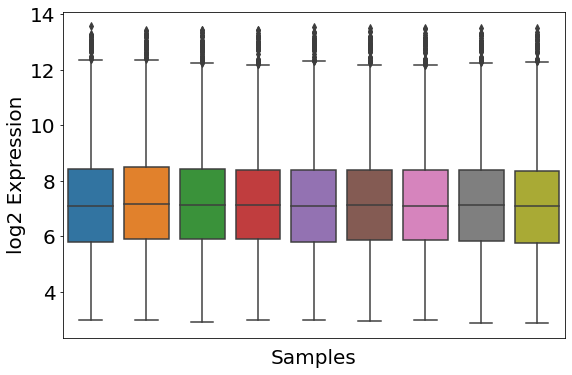

In [10]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression.iloc[:, 1:10], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression')
matplotlib.pyplot.show()

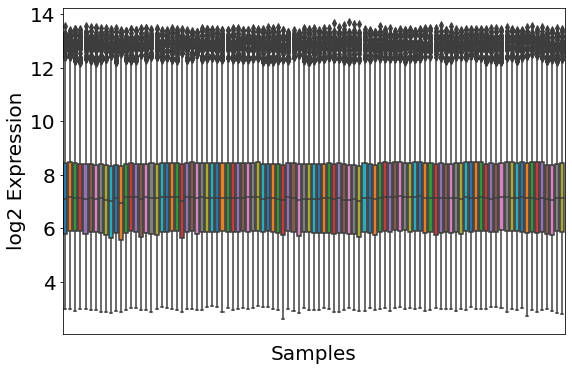

In [11]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression.iloc[:, 1:100], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression')
matplotlib.pyplot.show()

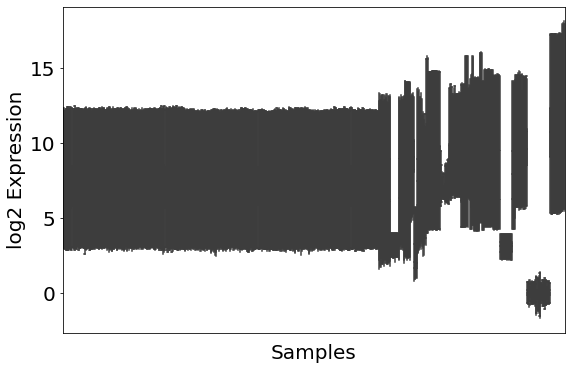

In [12]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression.iloc[:, 1:1000], palette='tab10', showfliers=False)
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression')
matplotlib.pyplot.show()

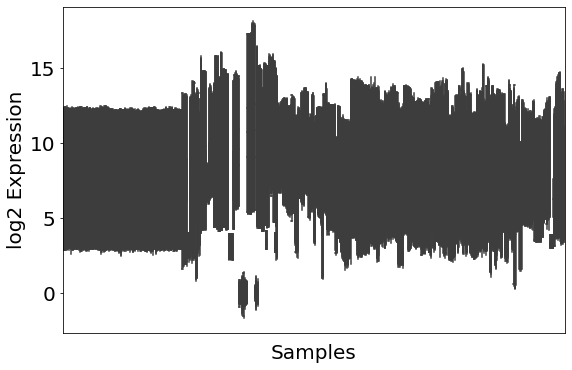

CPU times: user 18.5 s, sys: 101 ms, total: 18.6 s
Wall time: 18.6 s


In [13]:
%%time
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression.iloc[:, 1:expression.shape[1]], palette='tab10', showfliers=False)
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression')
matplotlib.pyplot.show()

## 2.2. quantile normalization

In [15]:
def quantile_normalization(df):
    
    "Quantile normalization consists on sorting, averaging and re-ordering."
    "For more information: https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/"
  
    # step 1/3: sorting sample values
    df_sorted = pandas.DataFrame(numpy.sort(df.values, axis=0), index=df.index, columns=df.columns)
    # step 2/3: averaging rank values across samples
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = numpy.arange(1, len(df_mean) + 1)
    # step 3/3: re-ordering samples
    df.rank(method="min").astype(int)
    df_qn = df.rank(method="min").stack().astype(int).map(df_mean).unstack()

    return df_qn

In [16]:
%%time
expression_qn = quantile_normalization(expression)

CPU times: user 4.64 s, sys: 1.07 s, total: 5.71 s
Wall time: 5.73 s


findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


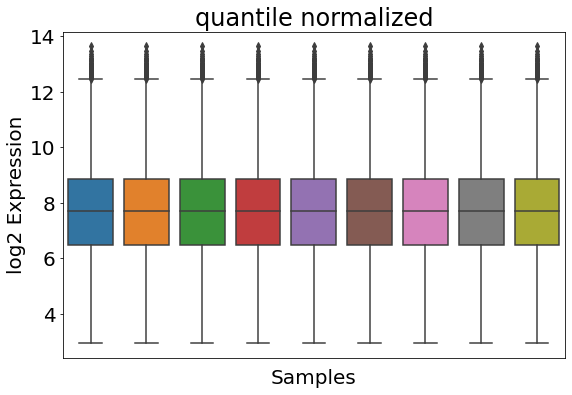

In [16]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression_qn.iloc[:, 1:10], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression', title='quantile normalized')
matplotlib.pyplot.show()

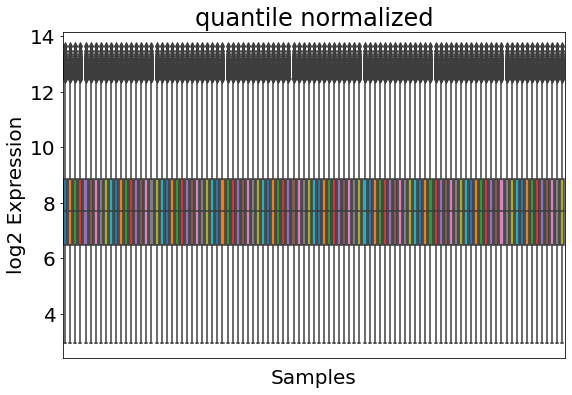

In [17]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression_qn.iloc[:, 1:100], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression', title='quantile normalized')
matplotlib.pyplot.show()

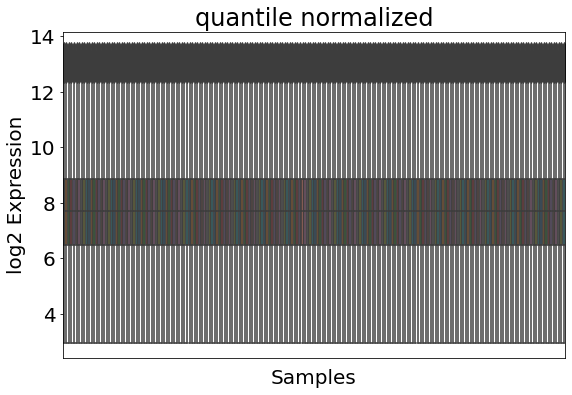

In [18]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression_qn.iloc[:, 2000:2200], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression', title='quantile normalized')
matplotlib.pyplot.show()

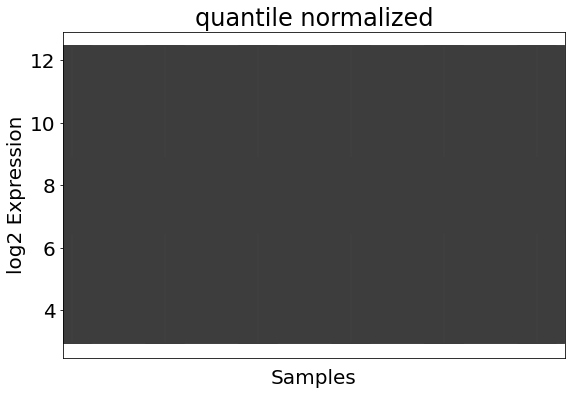

In [19]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression_qn.iloc[:, 1:1000], palette='tab10', showfliers=False)
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression', title='quantile normalized')
matplotlib.pyplot.show()

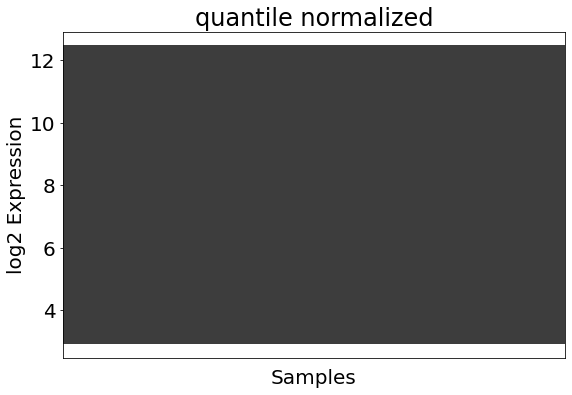

In [20]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression_qn.iloc[:, 1:expression.shape[1]], palette='tab10', showfliers=False)
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression', title='quantile normalized')
matplotlib.pyplot.show()

# 3. dimensionality reduction

In [17]:
transpose_expression_qn = expression_qn.transpose()
transpose_expression_qn.head()

,100,1000,10000,10005,10006,10007,10010,10013,10015,10019,...,9978,998,9984,9987,9988,9989,9990,9991,9993,9994
GSM752709.cel,6.674178,9.253471,4.348688,6.547967,8.226402,7.877847,5.749067,6.206224,10.636120,9.778866,...,10.163430,11.088139,8.392577,10.538061,7.682210,9.836996,5.061649,6.168413,6.018051,6.700115
GSM752710.cel,6.962708,9.450826,4.065701,6.769329,8.032836,7.895058,5.468747,6.288019,10.499423,9.397884,...,10.099152,11.525933,8.771970,10.807247,7.391308,9.823300,4.774275,5.997441,5.814616,6.052927
GSM752711.cel,6.274973,9.358252,4.198858,6.382631,8.411676,7.915058,6.250226,5.814616,10.653945,9.897394,...,10.110796,11.266447,8.381983,10.480788,7.975027,9.895337,4.552457,6.131025,6.048658,6.539920
GSM752712.cel,6.483298,9.347803,4.587900,6.334080,8.095503,8.000321,5.698585,5.916943,10.664650,9.821316,...,10.108416,11.124328,8.410712,10.373180,7.771491,9.835031,5.103788,6.311302,5.820957,6.340377
GSM752713.cel,7.144404,10.134623,4.490600,6.621219,8.016995,7.993288,5.666206,5.893772,10.632673,9.643835,...,10.120252,9.938836,8.628687,10.437714,7.318389,9.726615,4.523678,5.617235,6.151873,6.190025


## 3.1. tSNE

In [22]:
# testing_perplexity = numpy.linspace(5, 50, 25)
# testing_perplexity

In [23]:
# testing_early_exaggeration = numpy.linspace(5, 20, 15)
# testing_early_exaggeration

<timed exec>:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


CPU times: user 1min 12s, sys: 6.28 s, total: 1min 18s
Wall time: 10.9 s


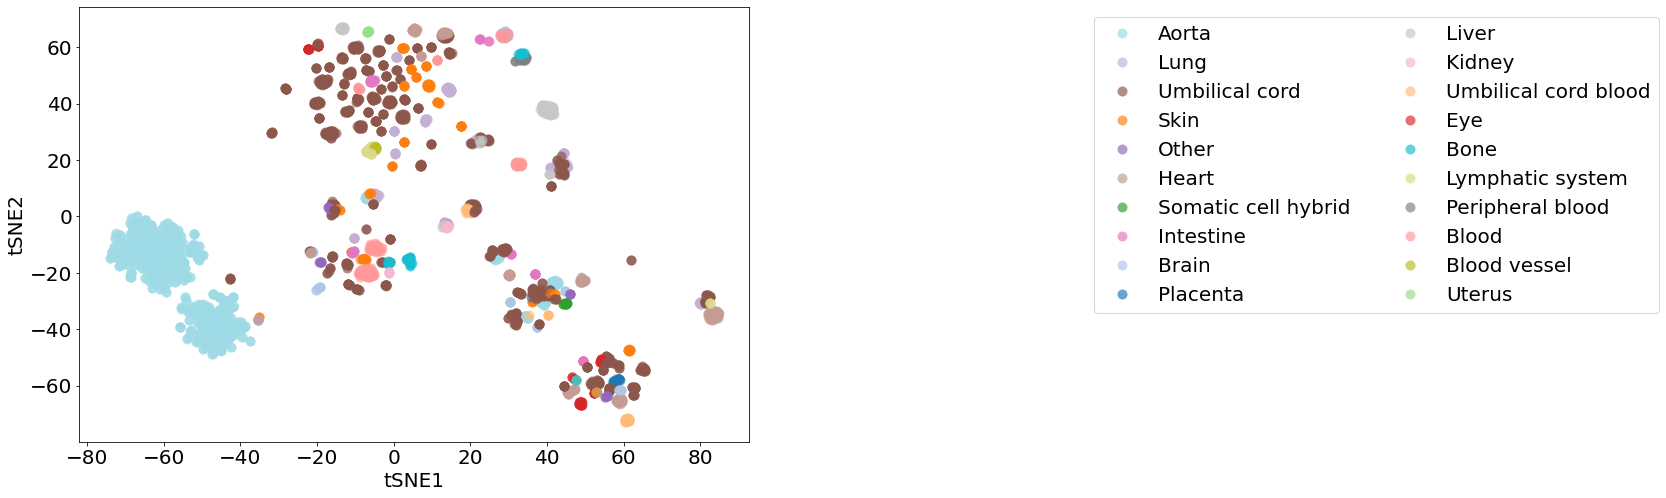

In [24]:
%%time

embedded = sklearn.manifold.TSNE(perplexity=45, init='pca', random_state=9).fit_transform(transpose_expression_qn)

matplotlib.pyplot.figure(figsize=(12, 8))
tagged_tissue = []

for i in range(len(embedded)):
    x = embedded[i, 0]
    y = embedded[i, 1]
    tissue = tissues_of_origin[i]

    if tissue not in tagged_tissue:
        matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0, label=tissue)
        tagged_tissue.append(tissue)
    else:
        matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0)

matplotlib.pyplot.legend(bbox_to_anchor=(1.5, 1), ncol=2)
matplotlib.pyplot.xlabel('tSNE1')
matplotlib.pyplot.ylabel('tSNE2')
matplotlib.pyplot.tight_layout(pad=2)
#matplotlib.pyplot.savefig('figures/tsne.{}.pdf'.format(working_parameter))

## 3.2. UMAP

In [25]:
# testing_values = numpy.linspace(25, 300, 25).astype('int')
# testing_values

<timed exec>:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


CPU times: user 31 s, sys: 352 ms, total: 31.4 s
Wall time: 28.7 s


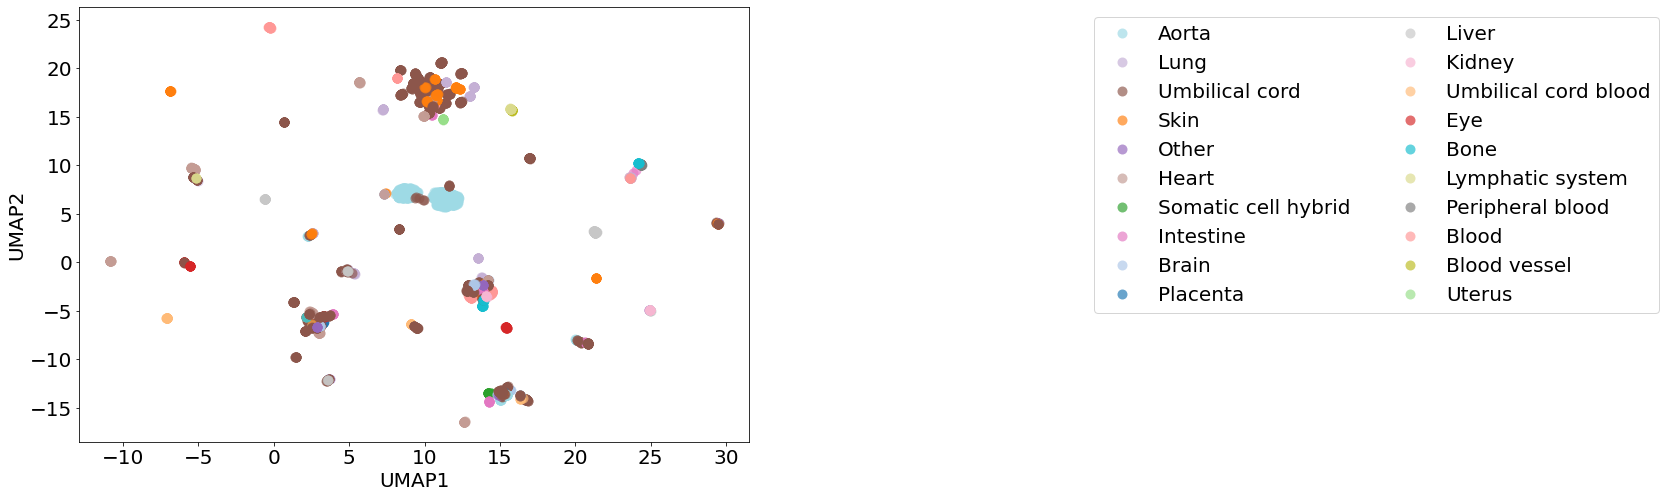

In [26]:
%%time

embedded = umap.UMAP(n_neighbors=80, min_dist=0.1, metric='cosine', random_state=9).fit_transform(transpose_expression_qn)

matplotlib.pyplot.figure(figsize=(12, 8))
tagged_tissue = []

for i in range(len(embedded)):
    x = embedded[i, 0]
    y = embedded[i, 1]
    tissue = tissues_of_origin[i]

    if tissue not in tagged_tissue:
        matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0, label=tissue)
        tagged_tissue.append(tissue)
    else:
        matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0)

matplotlib.pyplot.legend(bbox_to_anchor=(1.5, 1), ncol=2)
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.tight_layout(pad=2)
#matplotlib.pyplot.savefig('figures/umap.{}.pdf'.format(value))

## 3.3 PCA

In [18]:
scaled_data=sklearn.preprocessing.scale(transpose_expression_qn)

In [19]:
pca=PCA(n_components=2)

In [20]:
pca.fit(scaled_data)

PCA(n_components=2)

In [21]:
pca_data=pca.transform(scaled_data)

In [22]:
per_var=numpy.round(pca.explained_variance_ratio_*100,decimals=1)
labels=['Pc'+ str(x) for x in range(1,len(per_var)+1)]

findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


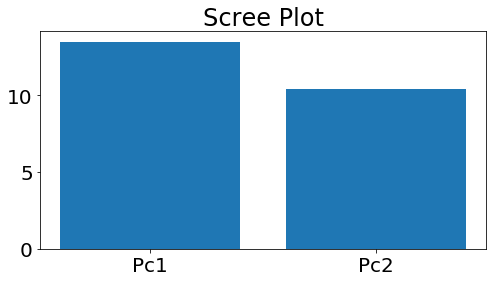

In [23]:
matplotlib.pyplot.bar(x=range(1,len(per_var)+1),height=per_var,tick_label=labels)
matplotlib.pyplot.title("Scree Plot")
matplotlib.pyplot.show()

In [24]:
principalDf = pandas.DataFrame(data = pca_data, columns = ['principal component 1', 'principal component 2'])

In [25]:
principalDf['Organ']=tissues_of_origin

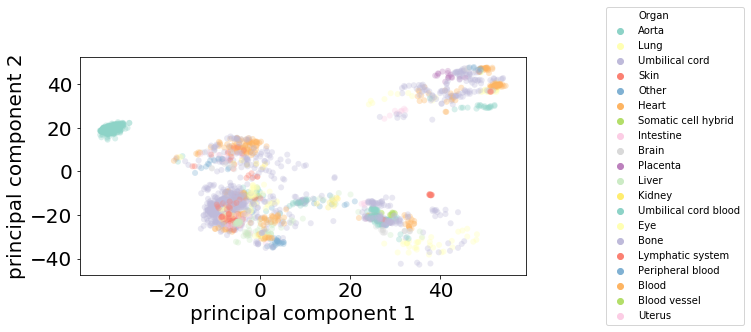

In [42]:
g=seaborn.scatterplot('principal component 1', 'principal component 2',data=principalDf, hue="Organ", palette="Set3",linewidth=0, alpha=1/3)
g.legend(loc='right', bbox_to_anchor=(1.5, .5), ncol=1, fontsize=10)
matplotlib.pyplot.show()

# 4. CV analysis

In [27]:
expression_qn.head()

,GSM752709.cel,GSM752710.cel,GSM752711.cel,GSM752712.cel,GSM752713.cel,GSM752714.cel,GSM752715.cel,GSM752716.cel,GSM752717.cel,GSM752718.cel,...,GSM46386.CEL,GSM46387.CEL,GSM46388.CEL,GSM46389.CEL,GSM46390.CEL,GSM46391.CEL,GSM46392.CEL,GSM46393.CEL,GSM46394.CEL,GSM46395.CEL
100,6.674178,6.962708,6.274973,6.483298,7.144404,7.220788,6.923905,6.937810,6.846293,7.152750,...,6.293228,6.534239,6.578697,6.742912,6.641251,6.680690,8.518564,8.018708,6.803907,6.682831
1000,9.253471,9.450826,9.358252,9.347803,10.134623,10.033171,10.268073,10.231386,10.643337,10.611442,...,9.374838,9.461932,9.981047,10.017765,9.875008,9.453999,9.576691,9.295847,9.149958,9.063993
10000,4.348688,4.065701,4.198858,4.587900,4.490600,4.486824,4.213578,4.183800,4.448572,4.594608,...,6.503164,6.500804,6.392547,6.857464,6.286730,6.499627,6.873678,6.888788,6.915876,6.956745
10005,6.547967,6.769329,6.382631,6.334080,6.621219,6.828782,6.701218,6.633548,6.520506,6.726995,...,7.586550,7.861450,7.501221,7.523943,7.382496,6.627876,7.248987,7.602272,7.653583,8.183978
10006,8.226402,8.032836,8.411676,8.095503,8.016995,7.860594,8.189388,7.952356,8.112309,7.932339,...,6.550235,6.309996,5.912284,5.608274,6.615719,6.180599,6.026818,6.890802,5.363720,6.268397


In [28]:
expression_statistics = pandas.DataFrame(expression_qn.mean(axis=1).to_dict(), index=['mean']).transpose()
deviations = expression_qn.std(axis=1).to_dict()
expression_statistics['std'] = pandas.Series(deviations)
expression_statistics['CV'] = expression_statistics['std'] / expression_statistics['mean']
expression_statistics

,mean,std,CV
100,7.711900,1.045379,0.135554
1000,8.745869,1.629556,0.186323
10000,6.090182,1.660054,0.272579
10005,6.336139,1.062841,0.167743
10006,7.646740,1.425574,0.186429
...,...,...,...
9989,9.409202,0.859925,0.091392
9990,5.858157,1.337978,0.228396
9991,7.305720,1.678291,0.229723
9993,6.804256,1.047933,0.154011


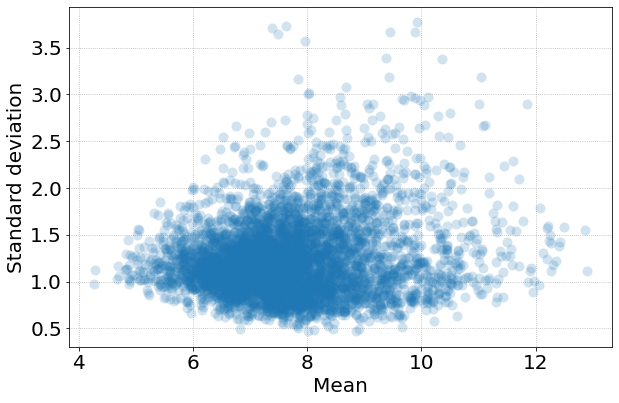

In [29]:
matplotlib.pyplot.figure(figsize=(9, 6))
matplotlib.pyplot.plot(expression_statistics['mean'], expression_statistics['std'], 'o', alpha=1/5, ms=10, mew=0)
matplotlib.pyplot.xlabel('Mean')
matplotlib.pyplot.ylabel('Standard deviation')
matplotlib.pyplot.grid(0.5, ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

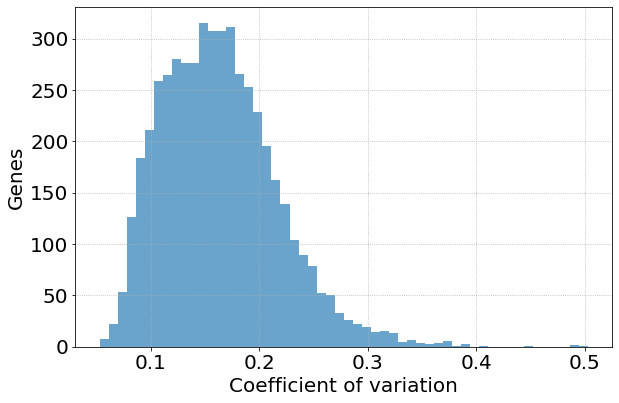

In [30]:
matplotlib.pyplot.figure(figsize=(9, 6))
tempo = matplotlib.pyplot.hist(expression_statistics['CV'].values, bins='auto', density=False, alpha=2/3)
matplotlib.pyplot.xlabel('Coefficient of variation')
matplotlib.pyplot.ylabel('Genes')
matplotlib.pyplot.grid(0.5, ls=':')
matplotlib.pyplot.tight_layout()

In [31]:
# consider plotting the expression profile for the top and bottom CV genes

# 5. Shannon entropy analysis

In [47]:
def Entropy(L):
    return entropy(L,base=2)

In [57]:
A_List_For_Test0=[1,1,1,1,1]

In [61]:
Entropy(pandas.Series(A_List_For_Test).value_counts())

0.0

In [64]:
A_List_For_Test1=[1,1,1,1,2]

In [65]:
Entropy(pandas.Series(A_List_For_Test1).value_counts())

0.7219280948873623

In [66]:
A_List_For_Test2=[1,1,1,2,2]

In [67]:
Entropy(pandas.Series(A_List_For_Test2).value_counts())

0.9709505944546688

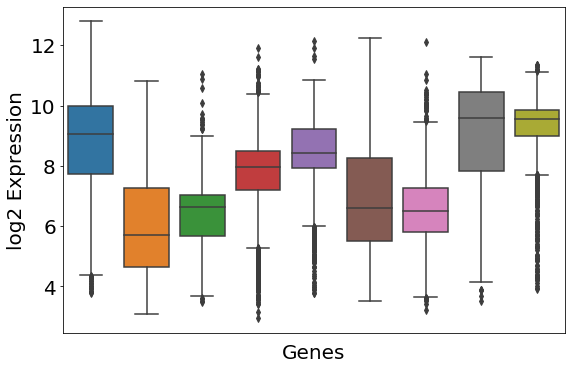

In [51]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression_qn.T.iloc[:, 1:10], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Genes', ylabel='log2 Expression')
matplotlib.pyplot.show()

In [44]:
# by histogram we check the disterbution of each gene in its interval.

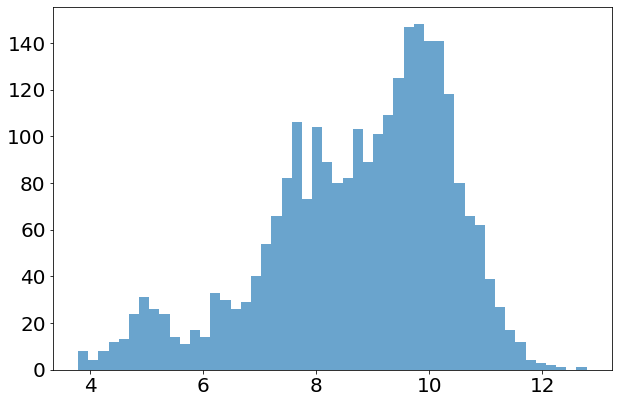

In [43]:
matplotlib.pyplot.figure(figsize=(9, 6))
tempo = matplotlib.pyplot.hist(transpose_expression_qn.iloc[:,1], bins=50, density=False, alpha=2/3)
matplotlib.pyplot.tight_layout()

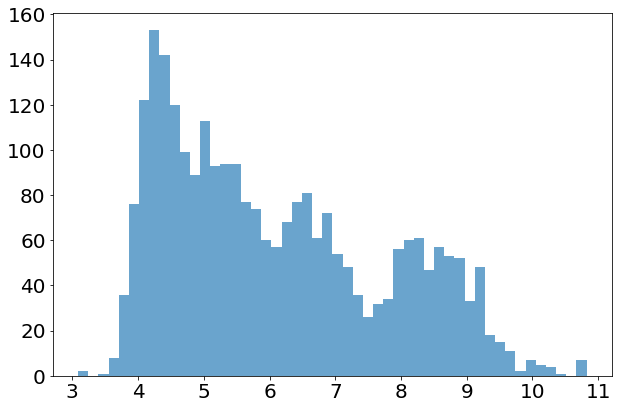

In [45]:
matplotlib.pyplot.figure(figsize=(9, 6))
tempo = matplotlib.pyplot.hist(transpose_expression_qn.iloc[:,2], bins=50, density=False, alpha=2/3)
matplotlib.pyplot.tight_layout()

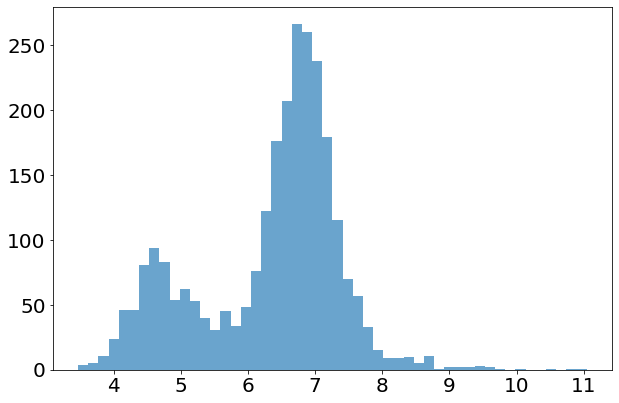

In [46]:
matplotlib.pyplot.figure(figsize=(9, 6))
tempo = matplotlib.pyplot.hist(transpose_expression_qn.iloc[:,3], bins=50, density=False, alpha=2/3)
matplotlib.pyplot.tight_layout()

In [48]:
expression_entropy= pandas.DataFrame(transpose_expression_qn.apply(Entropy).to_dict(), index=['intropy'])

In [49]:
expression_entropy

,100,1000,10000,10005,10006,10007,10010,10013,10015,10019,...,9978,998,9984,9987,9988,9989,9990,9991,9993,9994
intropy,11.351164,11.33739,11.311933,11.34301,11.337128,11.350662,11.322726,11.335313,11.345064,11.355292,...,11.355431,11.31731,11.358056,11.35017,11.357049,11.357537,11.328724,11.326913,11.346957,11.335409


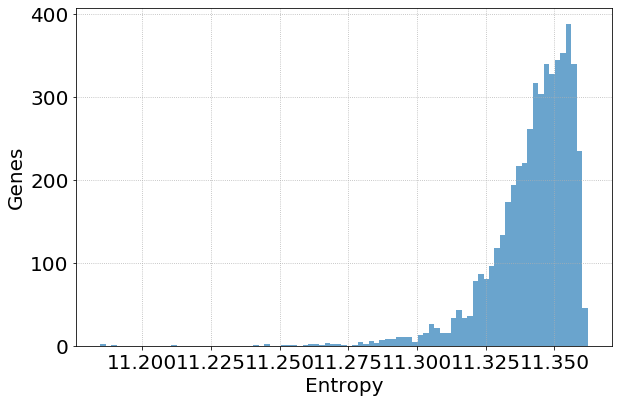

In [50]:
matplotlib.pyplot.figure(figsize=(9, 6))
tempo = matplotlib.pyplot.hist(expression_entropy, bins='auto', density=False, alpha=2/3)
matplotlib.pyplot.xlabel('Entropy')
matplotlib.pyplot.ylabel('Genes')
matplotlib.pyplot.grid(0.5, ls=':')
matplotlib.pyplot.tight_layout()

In [68]:
# Above figure is not correct

In [52]:
# chunking an interval into 100 pices(groups)  
def chunks(lst):
    EnL=[]
    m1=max(lst)
    m0=min(lst)
    d=(m1-m0)/100
    for i in range(0, 99):
        for j in lst:
            if m0+i*d<= j<m0+i*d+d:
                EnL.append(i)
    return EnL

In [53]:
ENC=transpose_expression_qn.apply(chunks)

In [54]:
ENC

100      [0, 2, 5, 5, 6, 6, 7, 7, 8, 9, 11, 11, 12, 12,...
1000     [0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4, ...
10000    [0, 1, 4, 6, 6, 6, 6, 6, 6, 7, 7, 8, 8, 8, 8, ...
10005    [0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, ...
10006    [0, 2, 5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, ...
                               ...                        
9989     [0, 1, 1, 3, 8, 10, 10, 10, 11, 12, 12, 13, 14...
9990     [0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 4, 4, ...
9991     [0, 0, 2, 3, 3, 5, 5, 5, 5, 6, 6, 7, 8, 8, 8, ...
9993     [0, 0, 1, 7, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 1...
9994     [0, 1, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, ...
Length: 4998, dtype: object

In [55]:
expression_entropy=[Entropy(pandas.Series(ENC.iloc[i]).value_counts()) for i in range(0,4998)]

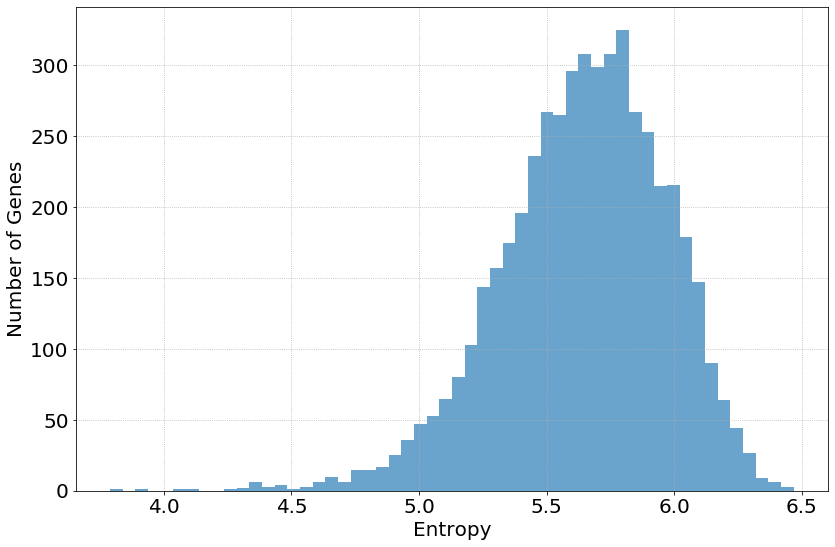

In [56]:
matplotlib.pyplot.figure(figsize=(12, 8))
tempo = matplotlib.pyplot.hist(expression_entropy, bins='auto', density=False, alpha=2/3)
matplotlib.pyplot.xlabel('Entropy')
matplotlib.pyplot.ylabel('Number of Genes')
matplotlib.pyplot.grid(0.5, ls=':')
matplotlib.pyplot.tight_layout()

In [75]:
a=numpy.random.choice(range(1,100),20)

In [78]:
b=numpy.random.choice(range(1,10),20)

In [79]:
Entropy(pandas.Series(a).value_counts())

2.9841837197791894

In [80]:
Entropy(pandas.Series(b).value_counts())

2.965957320949175

In [81]:
pandas.Series(b).value_counts()

5    5
8    3
3    3
7    2
6    2
1    2
9    1
4    1
2    1
dtype: int64

In [82]:
pandas.Series(a).value_counts()

7    4
4    4
5    3
9    2
8    2
1    2
6    1
3    1
2    1
dtype: int64